In [1]:
#! pip install mpi4py pylammpsmpi matplotlib numpy pandas

In [2]:
# Required imports
import pygad
import matplotlib.pyplot as plt
import lammps
import pandas as pd
import warnings

In [3]:
warnings.filterwarnings('ignore')

# Runs The lammps simulation with inputs as epsilon and sigma
def run_simulation(epsilon, sigma):

    # Initialize LAMMPS instance
    lmp = lammps.lammps()

    # Simulation parameters
    P = 0.986923  # atm
    Ti = 100  # K
    out = 10  # timestep
    step = 1  # fs
    runtime = 1000 # steps
    seed = 7545  # unitless
    Tdamp = 10  # timestep
    Pdamp = 100  # timestep

    # Setup commands
    lmp.command("units real")
    lmp.command("boundary p p p")
    lmp.command("atom_style atomic")
    lmp.command("atom_modify map array sort 0 0")

    # Read data file
    data_file = "argon.data"
    lmp.command(f"read_data {data_file}")

    # LJ potential setup for argon
    lmp.command("pair_style lj/cut 10.0")
    lmp.command(f"pair_coeff * * {epsilon} {sigma}")

    # Initialize velocities
    lmp.command(f"velocity all create {Ti} {seed}")

    # Neighbor and timestep settings
    lmp.command("neighbor 2.0 nsq")
    lmp.command("neigh_modify delay 0 every 1 check yes")
    lmp.command(f"timestep {step}")

    # Define thermo output style
    lmp.command(f"thermo {out}")
    lmp.command("thermo_style custom step density pe enthalpy")
    lmp.command("thermo_modify flush yes")

    # Fix for NPT simulation
    lmp.command(f"fix 1 all npt temp {Ti} {Ti} {Tdamp} iso {P} {P} {Pdamp}")

    # Run the simulation and return the properties
    lmp.command(f"run {runtime}")


In [4]:

# Parse The log file and returns The data as a Pandas Dataframe
def parse_log_file(file_path="log.lammps"):
    
    # As defined in the thermo style
    properties = ["Step","Density", "PotEng", "Enthalpy"]

    # Read the file and find the start of the thermo data
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Find the header line and the start of data
    header_index = None
    for i, line in enumerate(lines):
        if all(prop in line for prop in properties):
            header_index = i
            break

    if header_index is None:
        raise ValueError("Thermo data header with required properties not found in the log file.")

    # Determine the start and end indices of the data section
    footer_start_index = None
    for i in reversed(range(len(lines))):
        if lines[i].startswith("Loop time"):
            footer_start_index = i
            break

    if footer_start_index is None:
        raise ValueError("Footer section marker 'Loop time' not found.")

    # Read the thermo data lines into a list, excluding the footer lines
    thermo_data_lines = lines[header_index+1:footer_start_index]

    # Create a DataFrame from the thermo data lines
    data = pd.DataFrame([line.split() for line in thermo_data_lines], columns=properties)
    data = data.dropna()
    data[properties] = data[properties].apply(pd.to_numeric, errors='coerce')
    
    return data



In [5]:
# Calculate averages of defined properties over the bottom provided percentage data

def bottom_average(data,percentage=30):

    # can be a subset of the properties as defined in thermo style
    properties=["Density", "PotEng", "Enthalpy"]

    # Calculate the start index for the last `percentage`% of the data
    start_index = int((100 - percentage) / 100 * len(data))  # Convert percentage to start index

    # Select the last `percentage`% of the data
    last_percentage_data = data.iloc[start_index:]

    # Calculate averages for the last `percentage`% of the data
    averages = {prop: last_percentage_data[prop].mean() for prop in properties}

    return averages

In [6]:
# Calculate Average simulation properties as a function of epsilon and sigma

def calculate_properties(epsilon, sigma):
    
    run_simulation(epsilon,sigma)
    
    file_path="log.lammps"

    data = parse_log_file(file_path)

    averages = bottom_average(data,percentage = 40)

    return averages

In [7]:

def fitness_func(ga_instance, solution, solution_idx):
    
    epsilon, sigma = solution

    # Obtain properties
    global experimental_density,experimental_pe,experimental_enthalpy
    simulated_properties = calculate_properties(epsilon,sigma)
    simulated_density = simulated_properties['Density']
    simulated_pe = simulated_properties['PotEng']
    simulated_enthalpy = simulated_properties['Enthalpy']

    # Calculate errors (Need to manually define experimental properties in global scope)
    density_error = abs(simulated_density - experimental_density)
    potential_energy_error = abs(simulated_pe - experimental_pe)
    enthalpy_error = abs(simulated_enthalpy - experimental_enthalpy)

    # Return the negative errors because PyGAD maximizes the fitness function by default
    fitness = - (density_error + potential_energy_error + enthalpy_error )
    return fitness

In [8]:
def on_generation(ga_instance):
    print(f"Generation = {ga_instance.generations_completed}")
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    epsilon, sigma = solution
    print(f"Best solution in current generation: epsilon = {epsilon}, sigma = {sigma}")

### Do configurations Here:

In [9]:
# Configure

experimental_properties = {
    "Density": 1.2917936339041782,  
    "PotEng": -643.1172321148963,
    "Enthalpy": -492.8383454922379
}

experimental_density = experimental_properties["Density"]
experimental_pe = experimental_properties["PotEng"]
experimental_enthalpy = experimental_properties["Enthalpy"]

# Define the parameters' bounds
gene_space = [{'low': 0.1, 'high': 1.5},  # epsilon bounds
              {'low': 3.0, 'high': 4.0}]  # sigma bounds

# Number of generations
num_generations = 500
# Number of parents to select for mating
num_parents_mating = 25
# Population size
sol_per_pop = 40
# Number of genes (parameters to optimize)
num_genes = 2
# Duplicate genes
allow_duplicate_genes=False




### Main Driver code:

In [10]:
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    gene_space=gene_space,
    on_generation=on_generation,
    allow_duplicate_genes=allow_duplicate_genes,
    mutation_num_genes=1  # Ensure at least one gene is mutated
)
# Running the GA
ga_instance.run()

# Extracting the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
epsilon, sigma = solution
print(f"Best solution: epsilon = {epsilon}, sigma = {sigma}")
print(f"Fitness value of the best solution: {solution_fitness}")

# Optimal values are epsilon = 0.2385 sigma = 3.405

Generation = 1
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.4374078748664942
Generation = 2
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.4374078748664942
Generation = 3
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.2180199214232683
Generation = 4
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.0
Generation = 5
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.0
Generation = 6
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.0
Generation = 7
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.0
Generation = 8
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.0
Generation = 9
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.0
Generation = 10
Best solution in current generation: epsilon = 0.2318001505550989, sigma = 3.0
Generation = 1

### Plot 

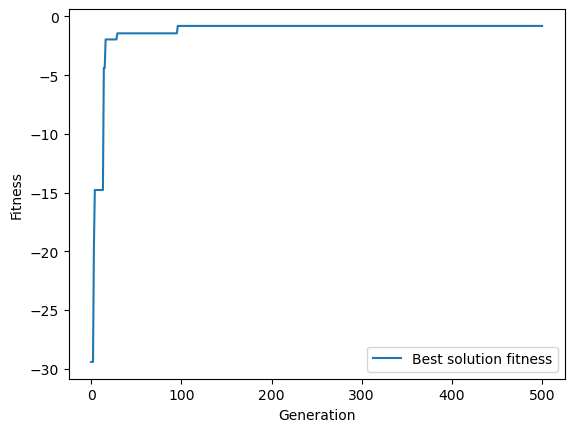

In [11]:
# Plot
plt.plot(ga_instance.best_solutions_fitness, label='Best solution fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()